In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np

In [3]:
nesting_start = 3
efficient = True
nesting_list = [2**i for i in range(nesting_start, 12)] # 8, 16, 32, 64, 128, 256, 512, 1024, 2048
num_classes = 10 # mnist = 10
model_path = "/home/iliam/dl-project/model/final_weights.pt"  # Update with your actual path

## Loading and checkind datasets

In [4]:
import torchvision
mnist_test = torchvision.datasets.MNIST('./mnist', download=True, train=False, transform=torchvision.transforms.ToTensor())
cifar10_test = torchvision.datasets.CIFAR10('./cifar10', download=True, train=False, transform=torchvision.transforms.ToTensor())

In [5]:
print(len(mnist_test))
input_image, target_class = mnist_test[0]
print(target_class)
input_image.shape

10000
7


torch.Size([1, 28, 28])

In [6]:
print(len(cifar10_test))
input_image, target_clasee = cifar10_test[0]
print(target_class)
input_image.shape

10000
7


torch.Size([3, 32, 32])

# Applying model + MRL to dataset

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
from tqdm import tqdm
from datasets import load_from_disk, Dataset
from PIL import Image
from mrl_loader import MRLLoader

model = MRLLoader(weights_path=model_path, num_classes=10)

/home/iliam/MRL-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initializing resnet50 model...


/home/iliam/MRL-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/iliam/MRL-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Applying BlurPool...
Loading weights from /home/iliam/dl-project/model/final_weights.pt...
Error loading weights: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.nesting_classifier_0.weight: copying a param with shape torch.Size([1000, 2048]) from checkpoint, the shape in current model is torch.Size([10, 2048]).
	size mismatch for fc.nesting_classifier_0.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([10]).
Continuing with pretrained weights only.
Model loaded on cuda
Available embedding dimensions: [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
Output embedding dimension set to 8


## Working with MNIST

In [8]:
def mnist_to_tensors(mnist_dataset):
    # Get all images and labels
    images = torch.stack([img for img, _ in mnist_dataset])
    labels = torch.tensor([label for _, label in mnist_dataset])
    
    # Add channel dimension if needed (MNIST usually has shape [N, H, W])
    if images.ndim == 3:
        images = images.unsqueeze(1)  # [N, 1, H, W]
    
    # Convert to 3-channel
    images = images.repeat(1, 3, 1, 1)
    
    return images, labels

mnist_images, mnist_labels = mnist_to_tensors(mnist_test)

In [9]:
print(mnist_labels)

tensor([7, 2, 1,  ..., 4, 5, 6])


In [10]:
mnist_embeds = model.extract_all_embeddings(mnist_images)
for dim, emb in mnist_embeds.items():
    print(f"Embedding dim {dim}: {emb.shape}")

Embedding dim 8: torch.Size([10000, 8])
Embedding dim 16: torch.Size([10000, 16])
Embedding dim 32: torch.Size([10000, 32])
Embedding dim 64: torch.Size([10000, 64])
Embedding dim 128: torch.Size([10000, 128])
Embedding dim 256: torch.Size([10000, 256])
Embedding dim 512: torch.Size([10000, 512])
Embedding dim 1024: torch.Size([10000, 1024])
Embedding dim 2048: torch.Size([10000, 2048])


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

def train_evaluate_logreg(embeddings_dict, labels, test_size=0.2, random_state=42):
    """
    Train and evaluate logistic regression classifiers for each embedding dimension.
    
    Args:
        embeddings_dict: Dictionary {dim: embeddings_tensor} where tensors are on CUDA
        labels: Tensor of corresponding labels
        test_size: Fraction of data to use for validation
        random_state: Random seed for reproducibility
        
    Returns:
        Dictionary of {dim: accuracy_score} for each dimension
    """
    # Convert labels to numpy (move to CPU if needed)
    labels_np = labels.cpu().numpy() if labels.is_cuda else labels.numpy()
    
    results = {}
    
    for dim, embeddings in embeddings_dict.items():
        # Convert embeddings to numpy (move to CPU if needed)
        emb_np = embeddings.cpu().numpy() if embeddings.is_cuda else embeddings.numpy()
        
        # Split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            emb_np, labels_np, 
            test_size=test_size, 
            random_state=random_state,
            stratify=labels_np  # Preserve class distribution
        )
        
        # Train logistic regression
        logreg = LogisticRegression(
            max_iter=1000,  # Increased for convergence
            solver='lbfgs',  # Good for multiclass
            random_state=random_state
        )
        logreg.fit(X_train, y_train)
        
        # Evaluate
        y_pred = logreg.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        results[dim] = accuracy
        
        print(f"Dimension {dim}: Test Accuracy = {accuracy:.4f}")
    
    return results

In [37]:
results = train_evaluate_logreg(mnist_embeds, mnist_labels, test_size=0.2, random_state=42)

Dimension 8: Test Accuracy = 0.1465
Dimension 16: Test Accuracy = 0.1690
Dimension 32: Test Accuracy = 0.2580
Dimension 64: Test Accuracy = 0.6055
Dimension 128: Test Accuracy = 0.8050
Dimension 256: Test Accuracy = 0.8705
Dimension 512: Test Accuracy = 0.9180
Dimension 1024: Test Accuracy = 0.9380
Dimension 2048: Test Accuracy = 0.9400


In [22]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

def train_evaluate_knn(embeddings_dict, labels, n_neighbors=5, test_size=0.2, random_state=42):

    # Convert labels to numpy (move to CPU if needed)
    labels_np = labels.cpu().numpy() if labels.is_cuda else labels.numpy()
    
    results = {}
    
    for dim, embeddings in embeddings_dict.items():
        # Convert embeddings to numpy (move to CPU if needed)
        emb_np = embeddings.cpu().numpy() if embeddings.is_cuda else embeddings.numpy()
        
        # Split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            emb_np, labels_np, 
            test_size=test_size, 
            random_state=random_state,
            stratify=labels_np  # Preserve class distribution
        )
        
        # Train logistic regression
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        clf.fit(X_train, y_train)
        
        # Evaluate
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        results[dim] = accuracy
        
        print(f"Dimension {dim}: Test Accuracy = {accuracy:.4f}")
    
    return results

def train_evaluate_svm(embeddings_dict, labels, test_size=0.2, random_state=42):

    # Convert labels to numpy (move to CPU if needed)
    labels_np = labels.cpu().numpy() if labels.is_cuda else labels.numpy()
    
    results = {}
    
    for dim, embeddings in embeddings_dict.items():
        # Convert embeddings to numpy (move to CPU if needed)
        emb_np = embeddings.cpu().numpy() if embeddings.is_cuda else embeddings.numpy()
        
        # Split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            emb_np, labels_np, 
            test_size=test_size, 
            random_state=random_state,
            stratify=labels_np  # Preserve class distribution
        )
        
        # Train logistic regression
        clf = svm.SVC()
        clf.fit(X_train, y_train)
        
        # Evaluate
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        results[dim] = accuracy
        
        print(f"Dimension {dim}: Test Accuracy = {accuracy:.4f}")
    
    return results

In [20]:
mnist_results_svm = train_evaluate_svm(mnist_embeds, mnist_labels, test_size=0.2, random_state=42)

Dimension 8: Test Accuracy = 0.1410
Dimension 16: Test Accuracy = 0.1575
Dimension 32: Test Accuracy = 0.2590
Dimension 64: Test Accuracy = 0.6135
Dimension 128: Test Accuracy = 0.8195
Dimension 256: Test Accuracy = 0.8710
Dimension 512: Test Accuracy = 0.8990
Dimension 1024: Test Accuracy = 0.9115
Dimension 2048: Test Accuracy = 0.9185


In [27]:
mnist_results_knn = train_evaluate_knn(mnist_embeds, mnist_labels, n_neighbors=5, test_size=0.2, random_state=42)

Dimension 8: Test Accuracy = 0.1285
Dimension 16: Test Accuracy = 0.1365
Dimension 32: Test Accuracy = 0.1990
Dimension 64: Test Accuracy = 0.5755
Dimension 128: Test Accuracy = 0.7680
Dimension 256: Test Accuracy = 0.8200
Dimension 512: Test Accuracy = 0.8420
Dimension 1024: Test Accuracy = 0.8580
Dimension 2048: Test Accuracy = 0.8660


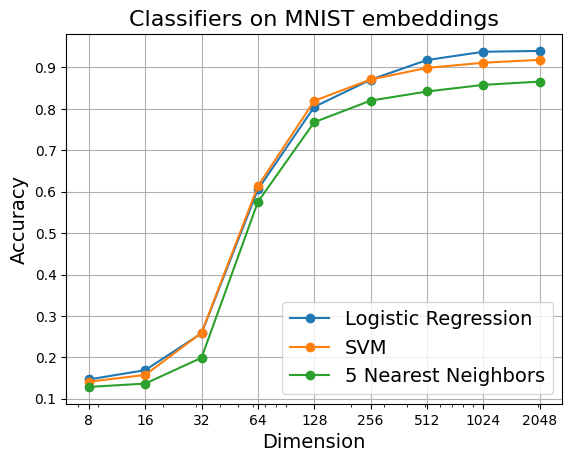

In [46]:
from matplotlib import pyplot as plt
dims = list(results.keys())
y_logreg = results.values()
y_svm = mnist_results_svm.values()
y_knn = mnist_results_knn.values()

plt.plot(dims, y_logreg, 'o-', label='Logistic Regression')
plt.plot(dims, y_svm, 'o-', label='SVM')
plt.plot(dims, y_knn, 'o-', label='5 Nearest Neighbors')
plt.title('Classifiers on MNIST embeddings', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Dimension', fontsize=14)
plt.xscale('log')
plt.xticks(dims, labels=dims)
plt.grid()
plt.legend(loc='best', fontsize=14)
plt.savefig("mnist.png", dpi=300, bbox_inches='tight')
plt.show()


## Working with cifar10

In [15]:
def cifar10_to_tensors(cifar10_dataset):
    # Get all images and labels
    images = torch.stack([img for img, _ in cifar10_dataset])
    labels = torch.tensor([label for _, label in cifar10_dataset])
    
    return images, labels

cifar10_images, cifar10_labels = cifar10_to_tensors(cifar10_test)

In [16]:
print(cifar10_images.shape)

torch.Size([10000, 3, 32, 32])


In [17]:
cifar10_embeds = model.extract_all_embeddings(cifar10_images)
for dim, emb in cifar10_embeds.items():
    print(f"Embedding dim {dim}: {emb.shape}")

Embedding dim 8: torch.Size([10000, 8])
Embedding dim 16: torch.Size([10000, 16])
Embedding dim 32: torch.Size([10000, 32])
Embedding dim 64: torch.Size([10000, 64])
Embedding dim 128: torch.Size([10000, 128])
Embedding dim 256: torch.Size([10000, 256])
Embedding dim 512: torch.Size([10000, 512])
Embedding dim 1024: torch.Size([10000, 1024])
Embedding dim 2048: torch.Size([10000, 2048])


In [48]:
cifar10_results = train_evaluate_logreg(cifar10_embeds, cifar10_labels, test_size=0.2, random_state=42)

Dimension 8: Test Accuracy = 0.1050
Dimension 16: Test Accuracy = 0.1150
Dimension 32: Test Accuracy = 0.1355
Dimension 64: Test Accuracy = 0.2405
Dimension 128: Test Accuracy = 0.3735
Dimension 256: Test Accuracy = 0.4430
Dimension 512: Test Accuracy = 0.4765
Dimension 1024: Test Accuracy = 0.4770
Dimension 2048: Test Accuracy = 0.4850


In [28]:
cifar10_results_svm = train_evaluate_svm(cifar10_embeds, cifar10_labels, test_size=0.2, random_state=42)

Dimension 8: Test Accuracy = 0.1005
Dimension 16: Test Accuracy = 0.1065
Dimension 32: Test Accuracy = 0.1310
Dimension 64: Test Accuracy = 0.2485
Dimension 128: Test Accuracy = 0.3845
Dimension 256: Test Accuracy = 0.4650
Dimension 512: Test Accuracy = 0.5010
Dimension 1024: Test Accuracy = 0.5290
Dimension 2048: Test Accuracy = 0.5535


In [29]:
cifar10_results_knn = train_evaluate_knn(cifar10_embeds, cifar10_labels, n_neighbors=5, test_size=0.2, random_state=42)

Dimension 8: Test Accuracy = 0.1030
Dimension 16: Test Accuracy = 0.1075
Dimension 32: Test Accuracy = 0.1195
Dimension 64: Test Accuracy = 0.1880
Dimension 128: Test Accuracy = 0.2730
Dimension 256: Test Accuracy = 0.3370
Dimension 512: Test Accuracy = 0.3810
Dimension 1024: Test Accuracy = 0.3915
Dimension 2048: Test Accuracy = 0.3995


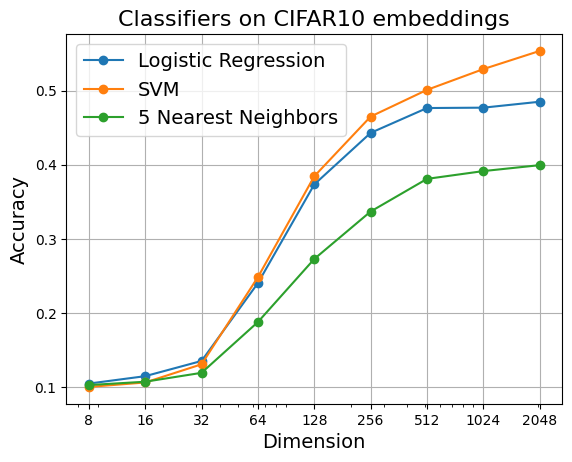

In [49]:
dims = list(results.keys())
y_logreg = cifar10_results.values()
y_svm = cifar10_results_svm.values()
y_knn = cifar10_results_knn.values()

plt.plot(dims, y_logreg, 'o-', label='Logistic Regression')
plt.plot(dims, y_svm, 'o-', label='SVM')
plt.plot(dims, y_knn, 'o-', label='5 Nearest Neighbors')
plt.title('Classifiers on CIFAR10 embeddings', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Dimension', fontsize=14)
plt.xscale('log')
plt.xticks(dims, labels=dims)
plt.grid()
plt.legend(loc='best', fontsize=14)
plt.savefig("cifar10.png", dpi=300, bbox_inches='tight')
plt.show()

## Working with CelebFaces

In [50]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class CelebAAttributesDataset(Dataset):
    def __init__(self, img_dir, attr_path, image_size=224):
        """
        Args:
            img_dir: Directory with all the images
            attr_path: Path to list_attr_celeba.csv
            image_size: Target image size
        """
        self.img_dir = img_dir
        self.image_files = sorted(os.listdir(img_dir))
        
        # Load and preprocess attributes
        self.attributes = pd.read_csv(attr_path)
        self.attributes.replace(-1, 0, inplace=True)  # Replace -1 with 0
        self.attr_names = self.attributes.columns[1:]  # Skip image_id column
        
        # Image transformations
        self.transform = transforms.Compose([
            transforms.CenterCrop(178),  # Original celebA is 218x178
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                                std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        
        # Get corresponding attributes
        img_id = self.image_files[idx]
        attrs = self.attributes[self.attributes['image_id'] == img_id].iloc[0,1:].values
        attrs = torch.tensor(attrs.astype('float32'))
        
        return image, attrs

image_folder = "/home/iliam/datasets/img_align_celeba/img_align_celeba"
attributes_folder = "/home/iliam/datasets/list_attr_celeba.csv"
dataset = CelebAAttributesDataset(img_dir=image_folder, attr_path=attributes_folder, image_size=224)
model = MRLLoader(weights_path=model_path, num_classes=2)

Initializing resnet50 model...


/home/iliam/MRL-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/iliam/MRL-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Applying BlurPool...
Loading weights from /home/iliam/dl-project/model/final_weights.pt...
Error loading weights: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.nesting_classifier_0.weight: copying a param with shape torch.Size([1000, 2048]) from checkpoint, the shape in current model is torch.Size([2, 2048]).
	size mismatch for fc.nesting_classifier_0.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([2]).
Continuing with pretrained weights only.
Model loaded on cuda
Available embedding dimensions: [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
Output embedding dimension set to 8


In [51]:
from tqdm import tqdm

def extract_celeba_embeddings(model, dataset, batch_size=32, device='cuda'):
    """
    Extract embeddings for CelebA images
    
    Args:
        model: Your embedding model
        dataset: CelebAAttributesDataset instance
        batch_size: Batch size for processing
        device: Device to use
        
    Returns:
        Tuple of (embeddings, attributes) where:
        - embeddings: Dictionary {dim: tensor_of_embeddings}
        - attributes: Tensor of all attributes
    """
    
    # Initialize storage
    available_dims = sorted(model.get_available_dimensions())
    embeddings = {dim: [] for dim in available_dims}
    all_attrs = []
    
    # Create dataloader
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Process batches
    for batch_imgs, batch_attrs in tqdm(dataloader, desc="Extracting embeddings"):
        batch_imgs = batch_imgs.to(device)
        
        batch_embeddings = model.extract_all_embeddings(batch_imgs)
            
        for dim in available_dims:
            embeddings[dim].append(batch_embeddings[dim].cpu())
            
        all_attrs.append(batch_attrs.cpu())
    
    # Concatenate results
    final_embeddings = {
        dim: torch.cat(emb_list, dim=0) 
        for dim, emb_list in embeddings.items()
    }
    final_attrs = torch.cat(all_attrs, dim=0)
    
    return final_embeddings, final_attrs

In [52]:
embeddings, attributes = extract_celeba_embeddings(
    model=model,
    dataset=dataset,
    batch_size=32
)

Extracting embeddings: 100%|██████████| 625/625 [01:12<00:00,  8.63it/s]


In [56]:
print(attributes.shape)

torch.Size([20000, 40])


In [57]:
print(embeddings)

{8: tensor([[0.6939, 0.7195, 3.6753,  ..., 1.0857, 1.1045, 0.3553],
        [2.2355, 2.0173, 3.0601,  ..., 1.3400, 2.5007, 1.1964],
        [1.8144, 1.3682, 2.6216,  ..., 0.5065, 2.4597, 1.0796],
        ...,
        [0.4675, 0.3045, 3.9064,  ..., 0.5736, 1.8378, 0.4113],
        [0.9913, 2.6246, 4.9359,  ..., 2.1845, 3.2820, 1.0388],
        [0.7721, 2.4770, 4.1156,  ..., 2.2470, 4.0993, 3.6328]]), 16: tensor([[0.6939, 0.7195, 3.6753,  ..., 0.8910, 1.8837, 0.0000],
        [2.2355, 2.0173, 3.0601,  ..., 0.1433, 1.8441, 0.0000],
        [1.8144, 1.3682, 2.6216,  ..., 0.3543, 2.0841, 0.0000],
        ...,
        [0.4675, 0.3045, 3.9064,  ..., 1.9297, 1.4940, 0.0000],
        [0.9913, 2.6246, 4.9359,  ..., 0.3413, 2.1379, 0.0000],
        [0.7721, 2.4770, 4.1156,  ..., 1.2319, 2.5138, 0.0000]]), 32: tensor([[0.6939, 0.7195, 3.6753,  ..., 1.2019, 0.2483, 2.6334],
        [2.2355, 2.0173, 3.0601,  ..., 0.7233, 0.1732, 1.9078],
        [1.8144, 1.3682, 2.6216,  ..., 0.4488, 0.7031, 1.4833]

In [66]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import pandas as pd

def evaluate_single_attribute(embeddings_dict, attributes, attr_idx=0, test_size=0.2, random_state=42):
    """
    Evaluate logistic regression on a single CelebA attribute
    
    Args:
        embeddings_dict: Dictionary {dim: embeddings_tensor}
        attributes: Tensor/array of shape [N, 40] with binary attributes
        attr_idx: Index of attribute to evaluate (default: 0)
        test_size: Fraction for validation
        random_state: Random seed
        
    Returns:
        Dictionary of {dimension: (accuracy, roc_auc, f1)}
    """
    # Convert to numpy if needed
    #attrs_np = attributes.cpu().numpy() if hasattr(attributes, 'is_cuda') else np.array(attributes)
    y = attributes[:, attr_idx]
    
    # Check if attribute has variance
    if len(np.unique(y)) < 2:
        raise ValueError(f"Attribute {attr_idx} has no variance (all values are the same)")
    
    results = {}
    
    for dim, embeddings in tqdm(embeddings_dict.items()):
        # Convert embeddings
        #emb_np = embeddings.cpu().numpy() if hasattr(embeddings, 'is_cuda') else np.array(embeddings)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            embeddings, y,
            test_size=test_size,
            random_state=random_state,
            stratify=y
        )
        
        # Train model
        logreg = LogisticRegression(
            max_iter=1000,
            solver='lbfgs',
            random_state=random_state
        )
        logreg.fit(X_train, y_train)
        
        # Predictions
        y_pred = logreg.predict(X_test)
        y_proba = logreg.predict_proba(X_test)[:, 1]
        
        # Store metrics
        results[dim] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'f1': f1_score(y_test, y_pred)
        }
    
    return results

In [69]:
def evaluate_single_attribute_knn(embeddings_dict, attributes, attr_idx=0, test_size=0.2, random_state=42):
    """
    Evaluate logistic regression on a single CelebA attribute
    
    Args:
        embeddings_dict: Dictionary {dim: embeddings_tensor}
        attributes: Tensor/array of shape [N, 40] with binary attributes
        attr_idx: Index of attribute to evaluate (default: 0)
        test_size: Fraction for validation
        random_state: Random seed
        
    Returns:
        Dictionary of {dimension: (accuracy, roc_auc, f1)}
    """
    # Convert to numpy if needed
    #attrs_np = attributes.cpu().numpy() if hasattr(attributes, 'is_cuda') else np.array(attributes)
    y = attributes[:, attr_idx]
    
    # Check if attribute has variance
    if len(np.unique(y)) < 2:
        raise ValueError(f"Attribute {attr_idx} has no variance (all values are the same)")
    
    results = {}
    
    for dim, embeddings in tqdm(embeddings_dict.items()):
        # Convert embeddings
        #emb_np = embeddings.cpu().numpy() if hasattr(embeddings, 'is_cuda') else np.array(embeddings)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            embeddings, y,
            test_size=test_size,
            random_state=random_state,
            stratify=y
        )
        
        # Train model
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(X_train, y_train)
        
        # Predictions
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:, 1]
        
        # Store metrics
        results[dim] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'f1': f1_score(y_test, y_pred)
        }
    
    return results

In [70]:
# Evaluate just the first attribute (index 0)
# check 2, 18, 19, 20, 21, 32, 37
results = evaluate_single_attribute_knn(embeddings, attributes, attr_idx=19)

# Pretty print results
for dim, metrics in results.items():
    print("Dimension \t Accuracy \t ROC AUC \t F1-Score")
    print(f"\t {dim} \t {metrics['accuracy']:.4f} \t {metrics['roc_auc']:.4f} \t {metrics['f1']:.4f}")
    print("-" * 100)

100%|██████████| 9/9 [00:08<00:00,  1.00it/s]

Dimension 	 Accuracy 	 ROC AUC 	 F1-Score
	 8 	 0.5985 	 0.6277 	 0.5666
----------------------------------------------------------------------------------------------------
Dimension 	 Accuracy 	 ROC AUC 	 F1-Score
	 16 	 0.5995 	 0.6343 	 0.5712
----------------------------------------------------------------------------------------------------
Dimension 	 Accuracy 	 ROC AUC 	 F1-Score
	 32 	 0.6152 	 0.6581 	 0.5919
----------------------------------------------------------------------------------------------------
Dimension 	 Accuracy 	 ROC AUC 	 F1-Score
	 64 	 0.6262 	 0.6704 	 0.6108
----------------------------------------------------------------------------------------------------
Dimension 	 Accuracy 	 ROC AUC 	 F1-Score
	 128 	 0.6420 	 0.6824 	 0.6253
----------------------------------------------------------------------------------------------------
Dimension 	 Accuracy 	 ROC AUC 	 F1-Score
	 256 	 0.6445 	 0.6917 	 0.6305
--------------------------------------------------